
# Random Orthogonal Measurements, Cosine Basis, ADMM

This example has following features:

* The image being measured is not sparse by itself.
* It does have a sparse representation in discrete cosine basis.
* Measurements are taken by a cosine ensemble ~partial Walsh Hadamard~ sensing matrix
  with small number of orthonormal rows
* The number of measurements is 8 times lower than the dimension of
  the signal space.
* ADMM based Basis pursuit denoising is being used to solve the recovery problem.

This example is adapted from YALL1 package.


Let's import necessary libraries 



In [1]:
import jax.numpy as jnp
from jax import random
norm = jnp.linalg.norm

import matplotlib as mpl
import matplotlib.pyplot as plt

from cr.sparse import lop
from cr.sparse.cvx.adm import yall1
import cr.nimble as cnb
import cr.sparse.dict as crdict

#import cv2 as cv 
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
import numpy as np
import os

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Setup



In [2]:
key = random.PRNGKey(0)
keys = random.split(key, 4)

## Image: Non-sparse signal



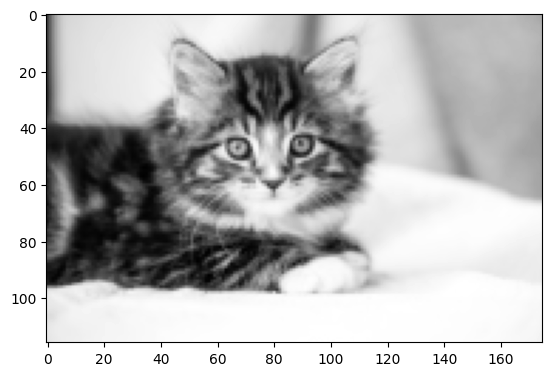

Number of pixels: 20300
Number of mesurements (50%): 10150


In [3]:
# Read and display the image
image_name = 'cat.jpg'
image = io.imread(os.path.join('images', image_name))
image_2 = rgb2gray(image)

# Resize image
scale_percent = 35 # percent of original size
width = int(image_2.shape[1] * scale_percent / 100)
height = int(image_2.shape[0] * scale_percent / 100)
dim = (height, width)
image_2 = resize(image_2, dim)
plt.imshow(image_2, cmap='gray')
plt.show()

# Flatten image
xs = jnp.array(image_2)/255
xs = xs.flatten()

# Ambient dimension
n = len(xs)
print(f'Number of pixels: {n}')

# Number of measurements
porcentage = 50
m = int(n*porcentage/100)
print(f'Number of mesurements ({porcentage}%): {m}')

## The Sparsifying Basis



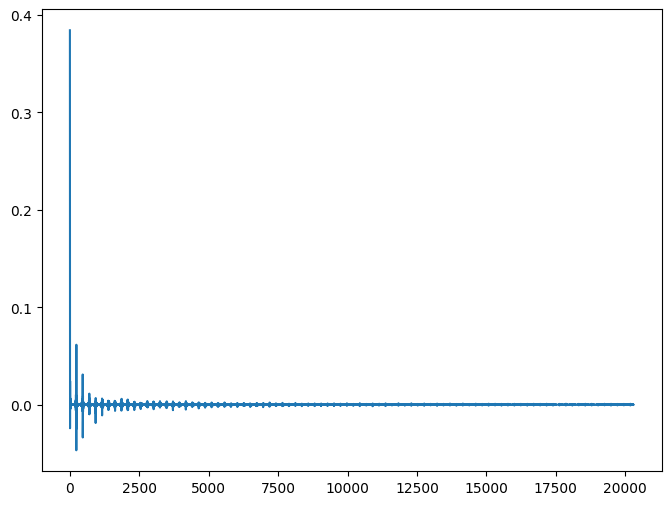

In [4]:
# Sparsifying basis
Psi = lop.jit(lop.cosine_basis(n))
#Psi = lop.jit(lop.walsh_hadamard_basis(n))

# Direct transformation
alpha = Psi.trans(xs)

# Plot transformation
plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(alpha)
plt.show()

## Orthogonal (cosine) ensemble measurement
_Function help_
- [partial_op()](https://carnotresearch.github.io/cr-sparse/_modules/cr/sparse/_src/lop/lop.html): builds a random ensemble from an orthogonal basis



In [5]:
# Indices of the measurements to be picked
p = random.permutation(keys[1], n)
picks = jnp.sort(p[:m])

# Make sure that DC component is always picked up
picks = picks.at[0].set(0)
print(f"picks = {picks}")

# A random permutation of input
perm = random.permutation(keys[2], n)
print(f"perm = {perm}")

# Cosine Basis operator
Twh = lop.cosine_basis(n)

# Wrap it with picks and perm
Tpwh = lop.jit(lop.partial_op(Twh, picks, perm))

picks = [    0     2     4 ... 20294 20295 20298]
perm = [18084 11817  5882 ... 14674  5440 11848]


## Measurement process

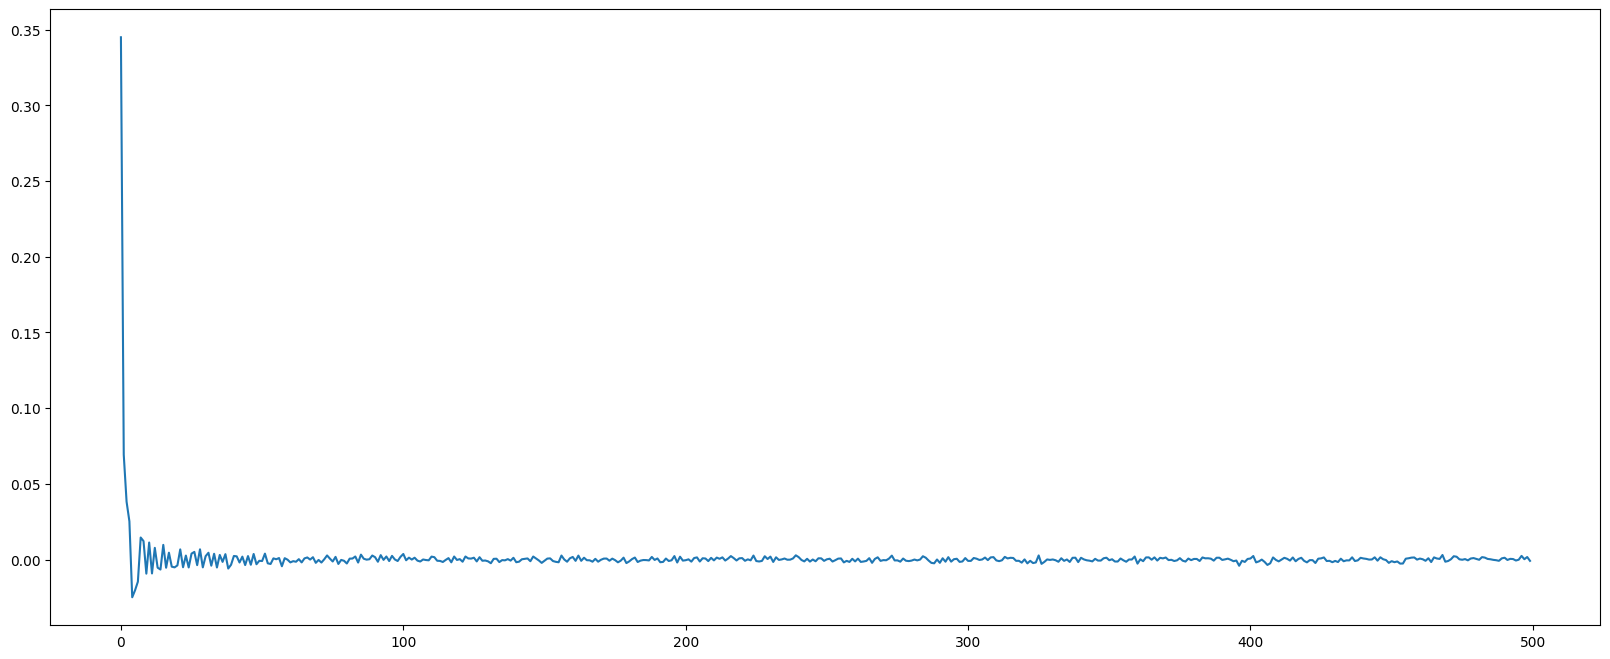

In [6]:
# Perform exact measurement
b = Tpwh.times(xs)

# Plot
plt.figure(figsize=(20, 8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(b[:500])
plt.show()

## Recovery using ADMM



In [7]:
# Tolerance for solution convergence
tol = 5e-4

# BPDN parameter
rho = 5e-4

# Run the solver
sol = yall1.solve(Tpwh, b, rho=rho, tolerance=tol, W=Psi)
iterations = int(sol.iterations)

# Number of iterations
print(f'Iterations: {iterations}')

# Relative error
rel_error = norm(sol.x-xs)/norm(xs)
print(f'Relative error: {rel_error:.4e}')

Iterations: 14
Relative error: 1.0011e-01


## Solution 



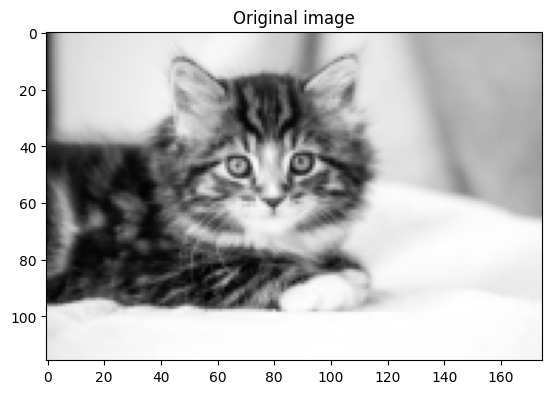

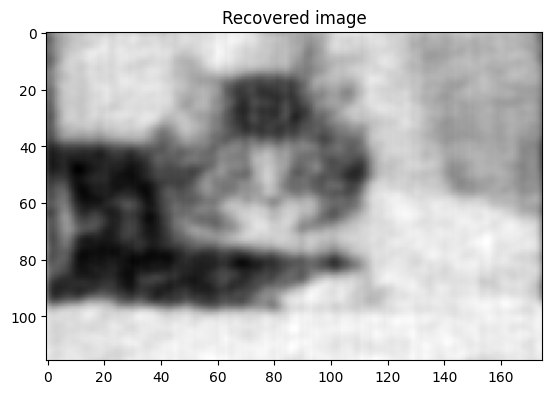

MSE: 5.5835e-03


In [8]:
# Original image
plt.imshow(image_2, cmap='gray')
plt.title("Original image")
plt.show()

# Recovered image
im_rec = sol.x.reshape(height, width)*255
plt.imshow(im_rec, cmap='gray')
plt.title("Recovered image")
plt.show()

# Compute MSE error of recovered image
mse = np.square(np.subtract(image_2, im_rec)).mean()
print(f"MSE: {mse:.4e}")

# # Postprocessing
# postprocessing_flag = False
# if postprocessing_flag:
#   im_rec = cv.cvtColor(np.array(im_rec), cv.COLOR_GRAY2RGB)
#   # Apply bilateral filter 
#   im_rec = cv.bilateralFilter(im_rec, 15, 25, 25)
#   plt.imshow(np.array(im_rec) / 255, cmap='gray')
#   plt.show()